# [Introductory applied machine learning (INFR10069)](https://www.learn.ed.ac.uk/webapps/blackboard/execute/content/blankPage?cmd=view&content_id=_2651677_1&course_id=_53633_1)

# Lab 5: Neural Networks

*by [James Owers](https://jamesowers.github.io/), University of Edinburgh 2017*

1. [Introduction](#Introduction)
    * [Lab Outline](#Lab-Outline)
    * [The Data](#The-Data)
1. [Part 1 - Introducing the Neural Network Model](#Part-1---Introducing-the-Neural-Network-Model)
    * [Resources to Watch and Read pt. 1](##Resources-to-Watch-and-Read-pt.-1)
    * [Model Design](#Model-Design)
    * [The Cost Space](#The-Cost-Space)
1. [Part 2 - Fitting the Model & Optimisation](#Part-2---Fitting-the-Model-&-Optimisation)
    * [Resources to Watch and Read pt. 2](#Resources-to-Watch-and-Read-pt.-2)
    * [Finding the Best Parameters](#Finding-the-Best-Parameters)
    * [Gradient Descent](#Gradient-Descent)
    * [Backpropagation](#Backpropagation)
1. [Part 3 - Implementation From Scratch](#Part-3---Implementation-From-Scratch!)
1. [Part 4 - Implementation With Sklearn](#Part-4---Implementation-with-Sklearn)
1. [Moar?!](#Please-sir...I-want-some-more)

## Import packages

In [1]:
# https://docs.python.org/2/library/__future__.html
# make printing and division act like python 3
from __future__ import division, print_function

# General
import sys
import os
import copy
from IPython.display import Image, HTML

# Data structures
import numpy as np 
import pandas as pd

# Modelling
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from scipy.optimize import check_grad

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Local module adjacent to this notebook
import iaml
from iaml.data import load_letters

# http://ipython.readthedocs.io/en/stable/interactive/magics.html
%matplotlib inline

## Introduction

This lab:
1. introduces a simple neural network model in a supervised learning setting
1. provides impetus to understand the fitting procedure of that, and other networks
1. encourages you to implement a model from scratch
1. models the same problem with the sklearn package
1. makes you think about what you've done!

It does not discuss in detail:
1. any of the plethora of different activation functions you can use e.g. RELUs, SELUs, Tanh, ...
1. how to initialise the parameters and why that matters
1. issues with the fitting process e.g. local optima, and how to avoid them e.g. learning rate schedulers, momentum, RMSProp, Adam, cyclic learning rates
1. issues with model complexity e.g. overfitting, and solutions such as dropout, regularisation, or using [shedloads of data](https://what-if.xkcd.com/63/)
1. other tricks for speeding up and stablising fitting such as batch sizes, weight norm, layer norm
1. deep networks and their tricks like skip connections, pooling, convolutions
1. nor other more complex architectures like CNNs, RNNs, LSTMs, GANs, etc. etc.
1. many, many, MANY other things (that probably were published, like, [yesterday](https://arxiv.org/abs/1711.04340v1))

However, if you understand what is in this notebook well, **you will have the ability to understand [all of these things](https://i.imgflip.com/1zn8p9.jpg)**.

### Lab outline

I provide you with a function that creates data then link you to some excellent resources to learn the basics. These resources are superb, short, and free. I highly, highly recommend setting aside a couple of hours to give them a good watch/read and, at the very least, use them for reference. 

After you have had a crack at the problems, I'll release the solutions. The solutions, particularly to part 3, walk you through the process of coding a simple neural neural network in detail.

Parts 3 & 4 are practical, parts 1 & 2 are links to external resources to read. Whilst I recommend you soak up some context first with 1 & 2, feel free to jump in at the deep end and get your hands dirty with part 3 or 4.

### The Data

Throughout this lab we are going to be using a simple classification example: the TC classification problem (not to be confused with the real [TC](https://www.youtube.com/watch?v=NToYkBYezZA)). This is a small toy problem where we, initially, try to distinguish between 3x3 grids that look like Ts and Cs. Let's create the dataset and have a look...

I have written a function `load_letters()` to generate synthetic data. For now, you will use the data generated below, but later you have opportunity to play with generating different data if you like. The function is located in the `iaml` module adjacent to this notebook - feel free to check out the code but I advise you **do not edit it**. Run (and don't edit) the next few cells to create and observe the data.

In [2]:
bounds = [-1, 1]
X, y, y_labels = load_letters(categories=['T', 'C'], 
                              num_obs=[50, 50],
                              bounds=bounds,
                              beta_params=[[1, 8], [8, 1]],
                              shuffle=True, 
                              random_state=42)

Let's print the data (I'm just creating a Pandas DataFrame for display, I probably wont use this object again)

In [3]:
pd.set_option("max_rows", 10)
df = pd.DataFrame(
    np.hstack(
        [np.around(X,2), 
         y[:, np.newaxis], 
         np.array([y_labels[ii] for ii in y])[:, np.newaxis]
        ]
    ),
    columns = ['x{}'.format(ii) for ii in range(9)] + ['Class (numeric)', 'Class Label']
)
df

,x0,x1,x2,x3,x4,x5,x6,x7,x8,Class (numeric),Class Label
0,0.66,0.89,0.83,-0.54,0.18,-0.58,-0.53,0.84,-0.9,0,T
1,0.77,0.9,0.92,0.72,-0.69,-0.31,0.98,0.86,0.94,1,C
2,0.19,0.96,0.91,-0.86,0.92,-0.91,-0.99,0.89,-0.55,0,T
3,0.79,0.51,0.97,-0.68,0.69,-0.93,-0.99,0.35,-0.81,0,T
4,0.46,0.73,0.94,-0.98,0.9,-0.77,-0.63,0.67,-0.79,0,T
...,...,...,...,...,...,...,...,...,...,...,...
95,0.68,0.64,0.95,-0.91,0.86,-0.95,-0.95,0.55,-0.96,0,T
96,0.0,0.26,0.96,-0.98,0.76,-0.95,-0.96,0.68,-0.87,0,T
97,0.7,0.98,0.86,0.83,-0.96,-1.0,0.95,0.85,0.99,1,C
98,0.78,0.49,0.96,-0.57,0.89,-0.99,-0.99,0.98,-0.51,0,T


In [4]:
pd.reset_option("max_rows")

The data are arranged as vectors for your convenience, but they're really `3 x 3` images. Here's a function to plot them.

In [5]:
def plot_grid(x, shape=None, **heatmap_params):
    """Function for reshaping and plotting vector data.
    If shape not given, assumed square.
    """
    if shape is None:
        width = int(np.sqrt(len(x)))
        if width == np.sqrt(len(x)):
            shape = (width, width)
        else:
            print('Data not square, supply shape argument')
    sns.heatmap(x.reshape(shape), annot=True, **heatmap_params)

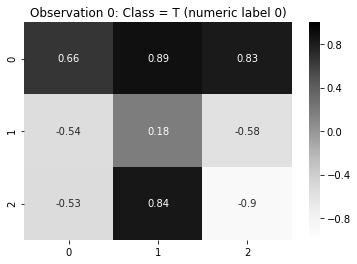

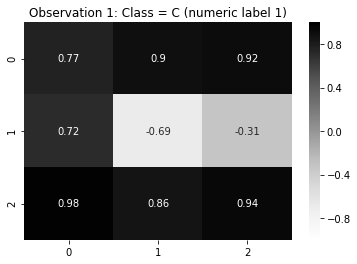

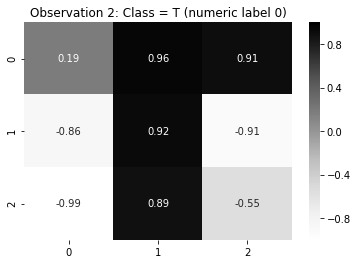

In [6]:
for ii in range(3):
    plt.figure()
    plot_grid(X[ii], vmin=bounds[0], vmax=bounds[1], cmap='Greys')
    plt.title('Observation {}: Class = {} (numeric label {})'.format(ii, y_labels[y[ii]], y[ii]))
    plt.show()

Finally, let's make the train and test split. Again, don't alter this code.

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.5, random_state=42)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train, y_train, test_size=0.33, random_state=42)

In [9]:
[dd.shape for dd in [X_train, X_valid, X_test, y_train, y_valid, y_test]]

[(33, 9), (17, 9), (50, 9), (33,), (17,), (50,)]

## Part 1 - Introducing the Neural Network Model

### Resources to Watch and Read pt. 1

**Reading/watching time:** 30 minutes

First, watch this video from 3 Blue 1 Brown: [But what *is* a Neural Network? | Deep learning, chapter 1](https://www.youtube.com/watch?v=aircAruvnKk)

If you prefer reading, try 2 sections of Nielsen's Book Chapter 1:
* [Sigmoid Neurons](http://neuralnetworksanddeeplearning.com/chap1.html#sigmoid_neurons)
* and [The Architecture of Neural Networks](http://neuralnetworksanddeeplearning.com/chap1.html#the_architecture_of_neural_networks)

### Model Design

Just so as there's something in this notebook to quickly reference - here's a nice illustration of what's going on in a neural net. Within the calculation of the $z$'s you'll see the learned **parameters**: $w$'s and $b$'s - these are the weights and biases respectively. *N.B. I omit the bias $b$ parameters in the Part 3 implementation.* The functions $g$ are the activation functions.

<img src="img/neural-net.png">

### The Cost Space

When we talk about the cost space, loss$^*$ space, or cost surface, we are talking about a function that changes with respect to the parameters. This function determines how well the network is performing - a low cost is good, a high cost is bad. A simple example for two parameters is shown below. **Our goal is to update the parameters such that we find the global minimum of the cost function.**

$^*$ 'loss' and 'cost' are interchangeable terms - you'll see them both around but I try to stick to 'cost'!

<img src="img/cost_space.png">

N.B. The cost function is often referred to with different letters e.g. $J(w)$, $C(\theta)$, $\mathcal{L}(x)$, and $E(w)$

## Part 2 - Fitting the Model & Optimisation

### Resources to Watch and Read pt. 2

**Watching/reading time:** ~1 hour

First, watch these two videos from 3 Blue 1 Brown:
1. [Gradient descent, how neural networks learn | Deep learning, chapter 2](https://www.youtube.com/watch?v=IHZwWFHWa-w)
2. [What is backpropagation and what is it actually doing? | Deep learning, chapter 3](https://www.youtube.com/watch?v=Ilg3gGewQ5U)

This will take you just over half an hour (if you watch at 1x speed). They are really excellent and well worth the time investment.

Again, if you prefer reading try Nielsen's section [Learning with Gradient Descent](http://neuralnetworksanddeeplearning.com/chap1.html#learning_with_gradient_descent)

### Finding the Best Parameters

So, we've got a function, let's call it $C(\theta)$ that puts a number on how well the neural network is doing. We provide the function with the parameters $\theta$ and it spits out the cost$^*$. We could just randomly chose values for $\theta$ and select the ones that result in the best cost...but that might take a long time. We'd also need to define a way to randomly select parameters as well. What if the best parameter setting is very unlikely to be selected?

**Calculus to the rescue!** The cost $C(\theta)$ is a function and, whilst we can't see the surface without evaluating it everywhere (expensive!), we can calculate the derivative with respect to the parameters $\frac{\partial C(\theta)}{\partial \theta}$. The derivative **tells you how the function value changes if you change $\theta$**. 

For example, imagine $\theta$ is 1D and I tell you that $\frac{\partial C(\theta)}{\partial \theta} = 10\theta$. This means that if I increase $theta$ by 2, the cost function will go up by 20. Which way will you update $\theta$? You want to *decrease* the cost, so you would want to *decrease* $\theta$ by some amount.

The only thing we need to do is choose a cost function $C(\theta)$ that has a derivative function $\frac{\partial C(\theta)}{\partial \theta}$...and that is easy!

$^*$It's much easier if you imagine $\theta$ as just one number to start with, but the maths is basically the same as $\theta$ becomes a vector (or matrix) of numbers.

### Gradient Descent

So how do we actually update the parameters?! All update the parameters in the opposite direction to the gradient; you always try to take a step 'downhill'. Here's the formula:

$$
\theta \leftarrow \theta - \eta \frac{\partial C(\theta)}{\partial \theta}
$$

where "$\leftarrow$" means "update from", and $\eta$ is the "learning rate" - a hyperparameter you can choose. If you increase $\eta$ you make bigger updates to $\theta$, and vice versa. 

There are many more complicated ways to update the parameters using the gradient of the cost function, but they all have this same starting point.

Below is an example cost surface. A few things to note:

* The axes should be labelled $\theta_0$ (1, -1.5) and $\theta_1$ (-1, 1) on the 'flat' axes, and $C(\theta)$ (-4, 4) on the vertical axis
* The surface is shown - we don't have direct access to this in reality. To show it, the creator has queried the cost function *at every [$\theta_0$, $\theta_1$] location* and plotted it
* The animated balls rolling along the surface are different gradient descent algorithms - each frame of the GIF shows one update. The equation shown above is SGD - the GIF highlights a potential issue with the algorithm!

<img src="https://i.imgur.com/2dKCQHh.gif">


Visualisation by [Alec Radford](https://blog.openai.com/tag/alec-radford/), summarised excellently in [this blog post](http://ruder.io/optimizing-gradient-descent/).

### Backpropagation

**Reading/watching time:** 1 hour

Right...it's time for some derivatives. If you've been liking the videos - go ahead and watch the next in the series:

1. [Backpropagation calculus | Appendix to deep learning chapter 3](https://www.youtube.com/watch?v=tIeHLnjs5U8)

If you have time, I recommend now having a crack at reading half of [Nielsen Chapter 2](http://neuralnetworksanddeeplearning.com/chap2.html), up to and including the section entitled [The Backpropagation Algorithm](http://neuralnetworksanddeeplearning.com/chap2.html#the_backpropagation_algorithm).

I'm just going to write out some derivatives you're going to find useful for Part 3 below:

$$
\begin{align}
z^{(L)}                             &= W^{(L)}a^{(L-1)}  \\
\frac{\partial z^{(L)}}{\partial W} &= a^{(L-1)}
\end{align}
$$

$$
\begin{align}
\text{linear}[z]                             &= z \\
\frac{\partial \text{linear}[z]}{\partial z} &= 1 \\
\end{align}
$$

$$
\begin{align}
\text{sigmoid}[z] = \sigma[z]                &= \frac{1}{1 + e^{-z}} = \frac{e^{z}}{e^{z} + 1}\\
\frac{\partial \sigma[z]}{\partial z}        &= \frac{e^{z}}{e^{z} + 1} - (\frac{e^{z}}{e^{z} + 1})^2 \\
                                             &= \frac{e^{z}}{e^{z} + 1} ( 1 - \frac{e^{z}}{e^{z} + 1} ) \\
                                             &= \sigma[z] (1 - \sigma[z])
\end{align}
$$

$$
\begin{align}
\text{crossentropy}[y, a] = C[y, a]       &= - \frac{1}{N} \sum_{i=1}^N y_i \log a_i + (1-y_i)\log(1-a_i) \\
\frac{\partial C[y_i, a_i]}{\partial a_i} &=  \frac{1 - y_i}{1 - a_i} + \frac{y_i}{a_i}
\end{align}
$$

And finally, this is all backpropagation really is...
$$
\begin{align}
\frac{\partial C[y_i, a_i]}{\partial w_j} &=  \frac{\partial a_i}{\partial w_j}\frac{\partial C[y_i, a_i]}{\partial a_i}\\
                                          &=  \frac{\partial z_k}{\partial w_j}\frac{\partial a_i}{\partial z_k}\frac{\partial C[y_i, a_i]}{\partial a_i}\\
\end{align}
$$


Challenge: derive these yourself.

#### Reading extension

For more on gradient based optimisers [check out this blog post](http://ruder.io/optimizing-gradient-descent/)

For another look at backpropagation - try [Christopher Olah's blog](http://colah.github.io/posts/2015-08-Backprop/)

## Part 3 - Implementation From Scratch!

### ========== Question 3.1 ==========

First thing is first: **don't get stuck on this**. I recommend you attempt this question for an hour and, if you don't get anywhere, move on to Question 3.2. You can even move straight on to Part 4. It's exactly the same problem addressed here in 3.1, but using sklearn instead of coding it yourself.

#### Model Specification

<img src="img/network_design.png" width="50%">

We are going to fit a very small neural network to classify the TC data. Here is the specification of the model:

1. Input of size 9
1. Hidden layer of size 3
    * Linear activation function
1. Output layer of size 1
    * Logistic activation function

As for the **cost function**: use Cross-Entropy. However, if you're getting bogged down with derivatives, feel free to try squared error to start with (this is what Nielsen and 3 Blue 1 Brown start with in their tutorials). Squared error is [not necessarily the right cost function to use](https://jamesmccaffrey.wordpress.com/2013/11/05/why-you-should-use-cross-entropy-error-instead-of-classification-error-or-mean-squared-error-for-neural-network-classifier-training/) but it will still work!

For a given input vector $x$, we can predict an output probability $a^{(2)}$ (were the $^{(2)}$ indicates the layer number, *not a power* - I'm following 3 Blue 1 Brown notation as best I can) using the following formula:

$$
\begin{align}
a^{(2)} &= f^{(2)}[z^{(2)}] \\
        &= f^{(2)}[W^{(2)}a^{(1)}] \\
        &= f^{(2)}[W^{(2)}f^{(1)}[z^{(1)}]] \\
        &= f^{(2)}[W^{(2)}f^{(1)}[W^{(1)}a^{(0)}]] \\
        &= f^{(2)}[W^{(2)}f^{(1)}[W^{(1)}x]] \\
        &= \sigma[W^{(2)}(W^{(1)}x)]
\end{align}
$$ 

where:

* $f^{(2)}$ is the activation function of the output layer (a sigmoid function $\sigma[]$)
* $f^{(1)}$ is the activation function of the hidden layer (the identity - 'linear activation')
* $W^{(2)}$ and $W^{(1)}$ are the parameters to learn
* $a^{(L)} = f^{(L)}[z^{(L)}]$ are the activations **exiting** layer $^{(L)}$
* $z^{(L)} = W^{(L)}a^{(L-1)}$ is the pre-activation weighted sum calculated **within** layer $^{(L)}$

The formula for the Cross-Entropy cost function is:

$$
C(a) = - \frac{1}{N} \sum_{i=1}^N y_i \log a_i + (1-y_i)\log(1-a_i)
$$

Notice how only one term in the sum is ever non-zero because $y_i$ is only ever 0 or 1. In our case, $N$ is the number of data observations in the dataset.

##### Parameters

The parameters of the model are two matrices:

1. $W^{(2)}$ - $3 \times 9$ matrix
    * used within the hidden layer (the $1^{st}$ layer) to get $z^{(1)} = W^{(1)}x$ for some $9 \times 1$ input vector $x$. $z^{(1)}$ is thus $3 \times 1$.
1. $W^{(1)}$ - $1 \times 3$ matrix
    * used within the output layer (the $2^{nd}$ layer) to get $z^{(2)} = W^{(2)}a^{(1)}$ for some $3 \times 1$ input vector $a^{(1)}$. $z^{(2)}$ is thus $1 \times 1$.

**Note that I'm not asking you to fit *bias parameters*.**

You'll often see parameters referred to as $\theta$, it's a catch all term. In our case it's just a list of all the weights, $\theta = [W^{(1)}, W^{(2)}]$. **We have 3 x 9 + 3 x 1 = 30 parameters to learn in total.**

##### Advice

You can use any of the equations and code I've given you or linked you to in this lab but **you do not have to!** You're free to code as you please. Personally, since this is a simple example, I did not do anything fancy (I didn't create any objects with methods and attributes). I simply:
* created a list containing the two parameter matrices `theta = [W1, W2]`
* created a function to do prediction (the forward pass)
* created a function to do the backward pass (updating the weights)
    * This is the tricky bit - I coded functions that are the [relevant derivatives](#http://localhost:8888/notebooks/10_Lab_5_Neural_Networks.ipynb#Backpropagation), and wrote code to iteratively pass back the 'deltas' - (I think Nielsen's equations [here](http://neuralnetworksanddeeplearning.com/chap2.html#the_backpropagation_algorithm) are very useful)  
* wrote a training loop which called these two main functions
    * each epoch calls the forward pass to predict, then the backward pass to update the parameters.

When the training was finished, my "model" was simply the parameters I had fitted, along with the 'forward pass' function - a function which uses those weights to predict a probability for any input data.

**You do not have to code it up like me**, you can do it however you like! The point of this part is for you to explore, code up all the equations, understand how to calculate the loss, and how to use that loss to update the parameters of the model by backpropagation.

**Debugging**: You're probably going to have issues particularly in the backprop section. You are welcome to make use of the `scipy.optimize.check_grad()` function. This takes as input a function f, g: a function that is (supposed to be) the function's derivative. 

If you didn't watch it already, now is a great time to take 10 minutes and watch [Backpropagation calculus | Appendix to deep learning chapter 3](https://www.youtube.com/watch?v=tIeHLnjs5U8)

#### ===== What you actually need to do for this question! =====

Write a training loop which uses gradient descent to learn the parameters. Each iteration of the loop is called an **epoch**. Run your code for *no more than 100 epochs*. You should be able to achieve 100% accuracy on this problem. 

In this case, for simplicity, you may initialise the weights to be samples from a normal distribution mean 0 variance 1, but please note that this [is not necessarily good practice](https://intoli.com/blog/neural-network-initialization/)!

**Do not code up a grid search for the learning rate hyperparameter**. You may instead play with the learning rate manually until you are happy. Try small values first like 0.0001 (if your backprop code is correct you **should** see your cost decreasing every epoch). Since this problem is so simple, a range of values should work. Again, with real data, you *must* do a search over hyperparameters, but here we are focussed on *coding* a working model.

To test whether or not what you have written has worked, please output the following:
1. After the training loop:
    1. plot a graph of training and validation loss against epoch number
    1. print or plot the final parameters you have learned using a Hinton diagram - feel free to use [code you can find online](http://bfy.tw/F74s)
    1. pick one weight parameter and produce a plot of its value against epoch number
        * Extension: do that for all the weights **leaving one specific input node** (i.e. the weights for one pixel of the input data)
    1. use your model to:
        1. print a few of the validation data examples and their predicted probabilities
        1. print the output for a T and C with no noise (you can make that input data yourself)
        1. print the output of a few random binary vectors i.e. 9x1 vectors of only 0s and 1s (again, you can make that input data yourself)

1. Within the training loop:
    1. print the training and validation crossentropy loss **and** percentage accuracy every epoch
    1. save the value of the training and validation losses for every epoch [for the plot after the loop]
    1. save the value of a weight parameter of your choice [for the plot after the loop]

#### ===== Example outputs =====

Below I give you some examples of what I'd like you to produce. **I produced these using a learning rate of 0.003, 100 epochs, and weights initialised with N(0,1) with a random seed of 42**. I found that you could learn faster i.e. you can use a larger learning rate, but I wanted to make smooth plots for you. 

You don't need to produce plots exactly like this, you can do them how you like, but try and display the same information. You can also use my plots for checking (if you use the same settings as me).

##### 1A

<img src="img/cost_per_epoch.png">

##### 1B

<img src="img/hinton_W1.png">

<img src="img/hinton_W2.png">

##### 1C

<img src="img/W1_x4__per_epoch.png">

##### 1D

<img src="img/predict_valid_0.png">

<img src="img/predict_valid_No noise T.png">

<img src="img/predict_valid_No noise C.png">

<img src="img/predict_valid_N(0, 1) sample 1.png">

<img src="img/predict_valid_N(0, 1) sample 2.png">

##### 2A

<img src="img/training_log.png">

In [10]:
# Your code goes here

#### Forward pass

In [11]:
def sigmoid(z):
    """Sigmoid activation function
    """
    return 1 / (1 + np.exp(-z))


def linear(z):
    """Linear activation function i.e. identity
    """
    return z


def predict(X, params, activation_funs, return_all=False):
    """Performs the 'forward pass' of the network which
    calculates the output $a^{(L)}$, the predicted probability for y i.e.
    the activation of the final layer
    
    Arguments
    ---------
    X : numpy array, The data, assumed N x D where N is the number of 
        observations and D the dimensionality
    params : list, each element is the weight parameters for successive layers
    activation_funs : list, each element is the activation function
        corresponding to each layer
    return_all : bool, whether to return a list of all the activations
        from each layer (set to True), or just to give the final predictions
        (Default: False)
    Returns
    -------
    if return_all is True:
        [activations, zs] : list, activations and zs are lists of numpy arrays
    if return_all is False:
    a : numpy array, the predicted probabilities i.e. the activations
        that are output from the final layer
    """
    activations = [X.T]
    zs = []
    for ii, (W, f) in enumerate(zip(params, activation_funs)):
        a_incoming = activations[ii]
        z = W.dot(a_incoming)
        a_outgoing = f(z)
        zs.append(copy.deepcopy(z))
        activations.append(copy.deepcopy(a_outgoing))
    if return_all:
        return [activations, zs]
    else:
        return activations[-1]


def crossentropy_cost(y, a):
    """Calculates the crossentropy cost (aka loss) for predictions a (the 
    activation output from the final layer) against true labels y. Assumes y is 
    binary data in [0, 1].
    
    See https://goo.gl/Aw7Q3i FMI.
    """
    nr_obs = len(y)
    # np.nan_to_num v useful for avoiding log(0) issues
    costs = (-y * np.log(a)) - ((1 - y) * np.log(1 - a)) 
    # if the true label y = 1:
    #     the first bracket gets very large as a goes to 1
    #     and the second bracket is 0
    # if the true label y = 0:
    #     the second bracket gets very large as a goes to 0
    #     and the first bracket is 0
    return np.nan_to_num(np.sum(costs)) / nr_obs


def squared_cost(y, a):
    """Calculates the sum of squared errors cost (aka loss) for predictions
    a (the activation output from the final layer) against true labels y.
    """
    nr_obs = len(y)
    costs = (a - y)**2 
    return np.sum(costs) / nr_obs

#### Backward pass (calculating the gradients and updating the parameters)

In [12]:
def crossentropy_cost_derivative(y, a):
    """Derivative of the crossentropy cost function w.r.t activation a.
    """
    # np.nan_to_num will help avoid division by 0 issues (generally as a -> y)
    cost_derivs = np.nan_to_num((1 - y) / (1 - a)) - np.nan_to_num(y / a)
    return np.nan_to_num(cost_derivs)


def squared_cost_derivative(y, a):
    """Derivative of the MSE cost function w.r.t activation a.
    """
    nr_obs = len(y)
    return 2*(a - y) / nr_obs


def sigmoid_derivative(z):
    """Derivative of sigmoid activation function w.r.t. z
    """
    return sigmoid(z) * (1 - sigmoid(z))


def linear_derivative(z):
    """Derivative of linear activation function i.e. identity w.r.t. z
    """
    return 1


def backward_pass(y, theta, fwd_pass_data, cost_fun_derivative, 
                  activation_funs_derivatives, learning_rate=0.001):
    """Performs the backward pass through the network.
    Returns updated parameters
    
    Arguments
    ---------
    y : array, the outcome data
    theta : list, each element is the weight parameters for successive layers
    fwd_pass_data : list, the output data from the forward pass [activations, zs]
        activations and zs are lists of numpy arrays corresponding to the activations
        and intermediatry zs for each neuron in each layer. These are used for 
        *evaluating* the derivatives. **Create these with the predict function**
    cost_fun_derivative : function, the function which returns the value of
        the cost function's derivative when supplied with the true labels y, and
        final layer activations a
    activation_funs_derivatives : list, list of functions. Each function returns the
        value of the derivative of the activation function of the layer (the index in the
        list indicates the layer number excluding the input layer)
    learning_rate : float, hyperparameter which determines the size of the step in the 
        direction of the negative gradient you should take when updating the parameters 
    
    Returns
    -------
    theta: list, same as input but updated
    
    """
    nr_layers = len(theta)
    activations, zs = fwd_pass_data
    
    ## Get the initial delta from the final layer (needs cost function derivative)
    delta = cost_fun_derivative(y, activations[-1]) * activation_funs_derivatives[-1](zs[-1])
    nablas = [None, None]  # https://en.wikipedia.org/wiki/Nabla_symbol
                           # These are the gradient values used to update the parameters
    nablas[-1] = np.dot(delta, activations[-2].transpose())
    
    ## Iterate *backwards* through the layers, passing deltas back and evaluating
    ## the derivatives w.r.t. the parameters (uses the forward pass activations and z's)
    ## N.B. for our initial model with 2 layers, this loop only has 1 iteration!
    for ii in range(2, nr_layers+1):
        W = theta[-ii + 1]                 # weights applied to the activations leaving this layer
        a_incoming = activations[-ii - 1]  # activations coming into this layer
        z = zs[-ii]                        # the z's calculated within this layer
        act_fun_deriv = activation_funs_derivatives[-ii]
        
        delta = np.dot(W.transpose(), delta) * act_fun_deriv(z)
        nablas[-2] = np.dot(delta, a_incoming.transpose())
        
    ## Update the parameters for each layer by gradient descent
    for ii in range(len(theta)):
        nabla = nablas[ii]
        W = theta[ii]
        theta[ii] = W - (learning_rate * nabla)
    return theta

In [13]:
def get_accuracy(y, a, decision_boundary=.5):
    """Convenience function for getting accuracy"""
    y_hat = (a > decision_boundary).astype(int)
    correct_predictions = np.sum(y == y_hat)
    accuracy = correct_predictions / len(y)
    return accuracy

#### Training Loop

In [14]:
# Settings
random_seed = 42
nr_epochs = 101  # The way I've written code means 11 epochs amounts to 10 parameter updates
activation_funs = [linear, sigmoid]
activation_funs_derivatives = [linear_derivative, sigmoid_derivative]
cost_fun = crossentropy_cost
cost_fun_derivative = crossentropy_cost_derivative
decision_boundary = .5
learning_rate = 0.003 # You can actually go a lot faster than this
                      # I chose to go slower for clearer graphs!

# Weight initialisation - N(0, 1): quick and dirty
## a better approach: http://neuralnetworksanddeeplearning.com/chap3.html#weight_initialization
np.random.seed(random_seed)
# W1 = 1/np.sqrt(9) * np.random.randn(3, 9)
# W2 = 1/np.sqrt(3) * np.random.randn(1, 3)
W1 = np.random.randn(3, 9)
W2 = np.random.randn(1, 3)
params = [W1, W2]

# Things to store
cost_per_epoch = dict(train=[], valid=[])
accuracy_per_epoch = dict(train=[], valid=[])
params_per_epoch = []


# Training loop
print('Beginning Training!\n{}\n'.format('-'*len('Beginning Training!')))
print(' {:^10} | {:^10} | {:^10} | {:^10} | {:^10} '.\
      format('Epoch', 'Train Cost', 'Valid Cost', 'Train Acc', 'Valid Acc'))
print(' {0}   {0}   {0}   {0}   {0} '.format(10*'-'))

for ii in range(nr_epochs):
    # WARNING: 
    # If your network is large and/or you are doing many epochs, it's not 
    # sensible to save the parameters every epoch - for this toy problem it's ok
    params_per_epoch.append(copy.deepcopy(params))  # without deepcopy, python will
                                                    # use a pointer only, resulting
                                                    # in a final parameter list with
                                                    # nr_epochs identical sets of params!
    # Forward pass
    fwd_pass_data = predict(X_train, params, activation_funs, return_all=True)
    activations = fwd_pass_data[0]

    a_out = dict(train=activations[-1],  # this is just to avoid calculating train output activations twice
                 valid=predict(X_valid, params, activation_funs, return_all=False))
    for dataset_name, (XX, yy) in dict(train=(X_train, y_train), 
                                       valid=(X_valid, y_valid)).iteritems():
        aa = a_out[dataset_name]
        accuracy_per_epoch[dataset_name].append(get_accuracy(yy, aa, decision_boundary))
        cost_per_epoch[dataset_name].append(cost_fun(yy, aa))
    
    print(' {:>10d} | {:<10.7f} | {:<10.7f} | {:<10.7f} | {:<10.7f} '.\
          format(ii, cost_per_epoch['train'][ii], cost_per_epoch['valid'][ii], 
                 accuracy_per_epoch['train'][ii], accuracy_per_epoch['valid'][ii]))
    
    # Don't do backward pass on the final epoch (just to avoid repeating code) 
    if ii == nr_epochs - 1:
        break
    
    # Backward pass
    params = backward_pass(y_train, params, fwd_pass_data, cost_fun_derivative, 
                           activation_funs_derivatives, learning_rate=learning_rate)

Beginning Training!
-------------------

   Epoch    | Train Cost | Valid Cost | Train Acc  | Valid Acc  
 ----------   ----------   ----------   ----------   ---------- 
          0 | 0.4854492  | 0.5377997  | 0.7878788  | 0.8823529  
          1 | 0.3681559  | 0.4001246  | 0.9090909  | 0.9411765  
          2 | 0.2959971  | 0.3146359  | 0.9696970  | 0.9411765  
          3 | 0.2468344  | 0.2564707  | 0.9696970  | 1.0000000  
          4 | 0.2109777  | 0.2143716  | 0.9696970  | 1.0000000  
          5 | 0.1835792  | 0.1825637  | 0.9696970  | 1.0000000  
          6 | 0.1619354  | 0.1577681  | 0.9696970  | 1.0000000  
          7 | 0.1444069  | 0.1379728  | 0.9696970  | 1.0000000  
          8 | 0.1299342  | 0.1218687  | 1.0000000  | 1.0000000  
          9 | 0.1177975  | 0.1085640  | 1.0000000  | 1.0000000  
         10 | 0.1074886  | 0.0974291  | 1.0000000  | 1.0000000  
         11 | 0.0986369  | 0.0880063  | 1.0000000  | 1.0000000  
         12 | 0.0909654  | 0.0799553  | 1.0000000

#### Results

##### 1A ---------------------------------

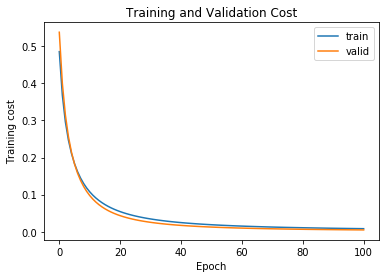

In [15]:
plt.figure()
for dataset_name in ('train', 'valid'):
    plt.plot(cost_per_epoch[dataset_name], label=dataset_name)
plt.xlabel('Epoch')
plt.ylabel('Training cost')
plt.title('Training and Validation Cost')
plt.legend() 
plt.savefig('./img/cost_per_epoch.png', dpi=100, bbox_inches='tight')
plt.show()

##### 1B ---------------------------------

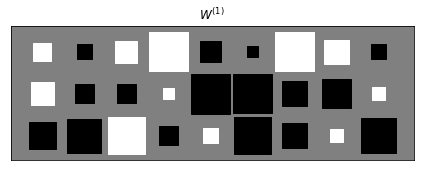

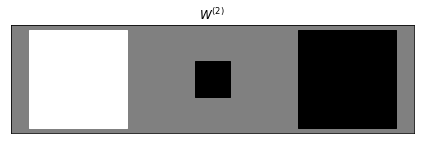

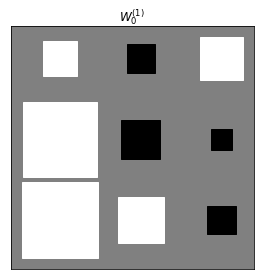

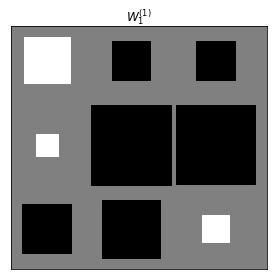

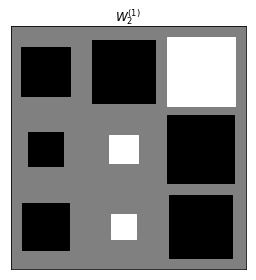

In [16]:
def hinton(matrix, max_weight=None, ax=None):
    """Draw Hinton diagram for visualizing a weight matrix.
    Source: https://matplotlib.org/examples/specialty_plots/hinton_demo.html
    """
    ax = ax if ax is not None else plt.gca()

    if not max_weight:
        max_weight = 2 ** np.ceil(np.log(np.abs(matrix).max()) / np.log(2))

    ax.patch.set_facecolor('gray')
    ax.set_aspect('equal', 'box')
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())

    for (x, y), w in np.ndenumerate(matrix):
        color = 'white' if w > 0 else 'black'
        size = np.sqrt(np.abs(w) / max_weight)
        rect = plt.Rectangle([x - size / 2, y - size / 2], size, size,
                             facecolor=color, edgecolor=color)
        ax.add_patch(rect)

    ax.autoscale_view()
    ax.invert_yaxis()

final_params = params_per_epoch[-1]

for ii, W in enumerate(final_params):
    plt.figure()
    hinton(W.T)
    plt.title('$W^{{({})}}$'.format(ii + 1))
    plt.tight_layout()
    plt.savefig('img/hinton_W{}.png'.format(ii + 1), dpi=100, bbox_inches='tight')
    plt.show()

W1 = final_params[0]
for ii in range(3):
    plt.figure()
    hinton(W1[ii, :].reshape(3, 3).T)
    plt.title('$W^{{({})}}_{}$'.format(1, ii))
    plt.savefig('img/hinton_W{}_{}.png'.format(1, ii), dpi=100, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

##### 1C ---------------------------------

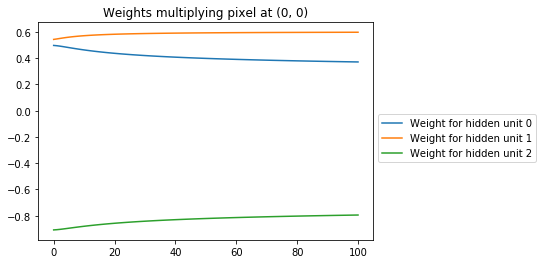

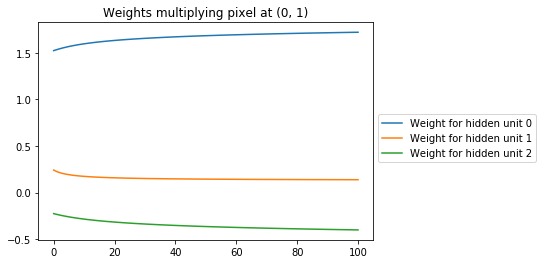

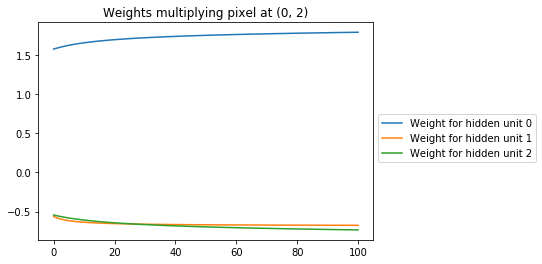

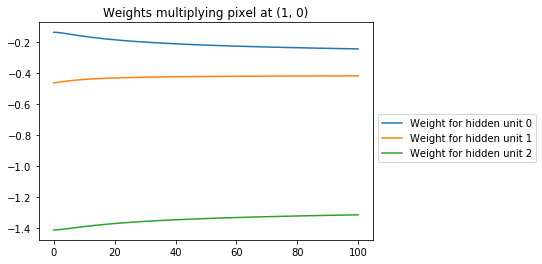

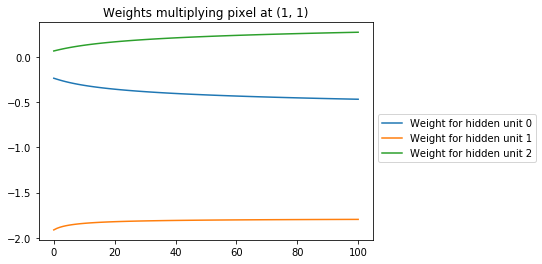

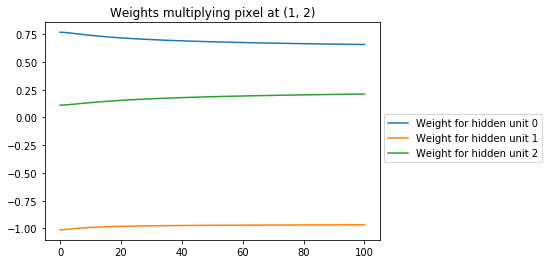

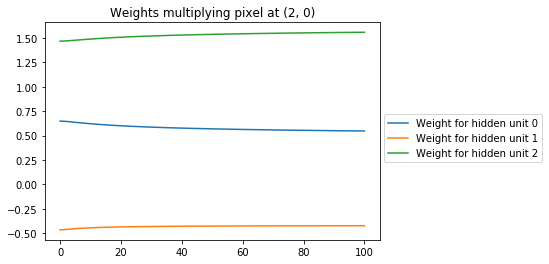

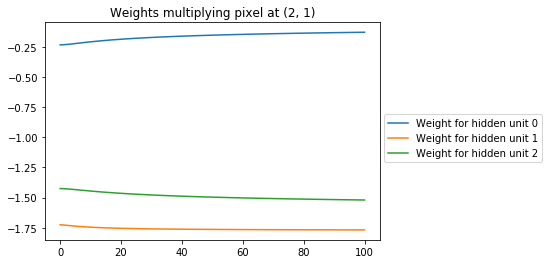

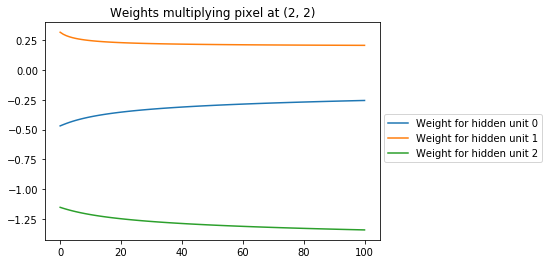

In [17]:
# I disregard my instructions, and show the plots for weights leaving every input data pixel (seeing as there aren't many)
# You need only plot a single weight over time, I'm just showing off.
W1_per_epoch = [W1 for W1, W2 in params_per_epoch]
for ii in range(3):
    for jj in range(3):
        plt.figure()
        plt.title('Weights multiplying pixel at ({}, {})'.format(ii, jj))
        idx = ii + 3*jj
        weights_over_time = [W1[:, idx] for W1 in W1_per_epoch]
        lines = plt.plot(weights_over_time)
        plt.legend(handles=lines, labels=['Weight for hidden unit {}'.format(kk) for kk in range(3)],
                   bbox_to_anchor=[1.5, .6])
        plt.savefig('img/W1_x{}__per_epoch.png'.format(idx), dpi=100, bbox_inches='tight')
        plt.show()

##### 1D ---------------------------------

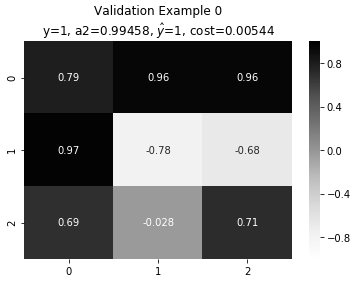

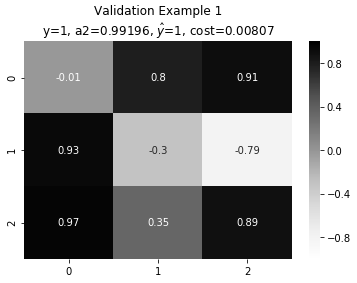

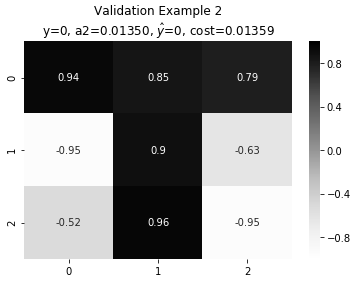

In [18]:
data = [X_valid, y_valid]
# nr_examples = y_valid.shape[0]
nr_examples = 3
for ii in range(nr_examples):
    xx, yy = data[0][ii, :], data[1][ii]
    yy = np.array([yy])
    plt.figure()
    plot_grid(xx, vmin=bounds[0], vmax=bounds[1], cmap='Greys')
    aa = predict(xx, params, activation_funs)[0]
    y_hat = (aa > decision_boundary).astype(int)
    cost = cost_fun(yy, aa)
    plt.title('Validation Example {}\n'
              'y={}, a2={:.5f}, $\hat{{y}}$={}, cost={:.5f}'.format(ii, yy[0], aa, y_hat, cost))
    plt.savefig('img/predict_valid_{}.png'.format(ii), dpi=100, bbox_inches='tight')
    plt.show()

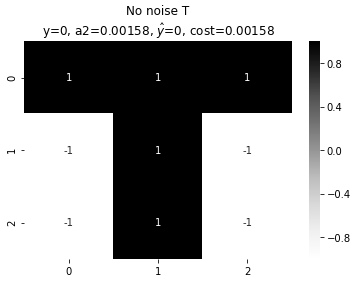

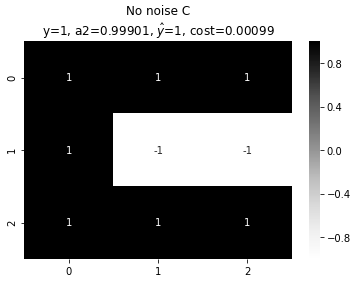

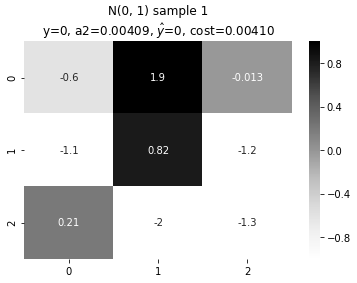

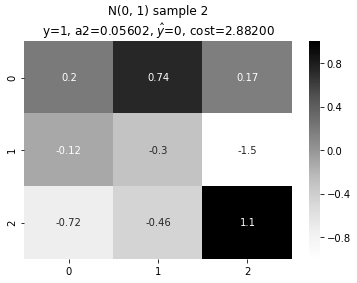

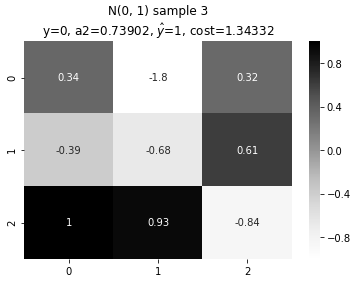

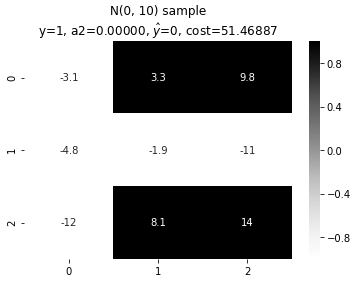

In [19]:
XX = np.array([2*iaml.data.LETTERMATS['T']-1,
               2*iaml.data.LETTERMATS['C']-1,
               np.random.randn(9),
               np.random.randn(9),
               np.random.randn(9),
               10*np.random.randn(9)])
yy = np.array([0, 1, 0, 1, 0, 1])
names = ['No noise T', 'No noise C', 'N(0, 1) sample 1', 'N(0, 1) sample 2', 'N(0, 1) sample 3', 'N(0, 10) sample']
data = [XX, yy]
nr_examples = len(yy)
for ii in range(nr_examples):
    xx, yy = data[0][ii, :], data[1][ii]
    yy = np.array([yy])
    plt.figure()
    plot_grid(xx, vmin=bounds[0], vmax=bounds[1], cmap='Greys')
    aa = predict(xx, params, activation_funs)[0]
    y_hat = (aa > decision_boundary).astype(int)
    cost = cost_fun(yy, aa)
    plt.title('{}\n'
              'y={}, a2={:.5f}, $\hat{{y}}$={}, cost={:.5f}'.format(names[ii], yy[0], aa, y_hat, cost))# 
    plt.savefig('img/predict_valid_{}.png'.format(names[ii]), dpi=100, bbox_inches='tight')
    plt.show()

##### ------------ Below here is some extra stuff, I didn't ask you for it ------------

#### A quick forward pass test

Here I test a few random parameter initialisations to see if the forward pass is working. **I'm not doing any learning here**, I'm just randomly picking values from a normal distribution for all the weights. The reason I'm doing this is to see if the cost function values look sensible, and to check if my code works!

Ultimately, as you'll see, I end up concluding that learning is going to be pretty easy for any initialisation we start on!

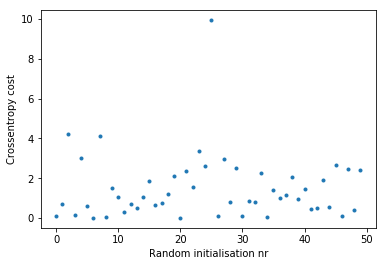

In [20]:
activation_funs = [linear, sigmoid]
cost_fun = crossentropy_cost
costs = []
param_list = []
for ii in range(50):
    np.random.seed(ii)
    W1 = np.random.randn(3, 9)
    W2 = np.random.randn(1, 3)
    params = [W1, W2]
    a2 = predict(X_train, params, activation_funs)
    cost = cost_fun(y_train, a2)
    costs.append(cost)
    param_list.append(params)
plt.figure()
plt.plot(costs, '.')
plt.xlabel('Random initialisation nr')
plt.ylabel('Crossentropy cost')
plt.show()

<font color="red">Hmm...that's interesting. We seem to have some random weight initialisations with really low costs! Let's check out the predictions we get using the best performing parameters from our random search of weights...</font>

In [21]:
idx_min = np.argmin(costs)
params_min = param_list[idx_min]

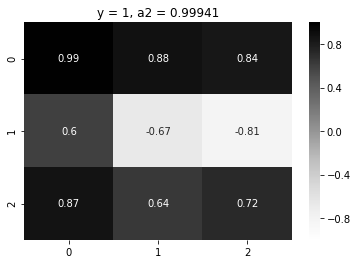

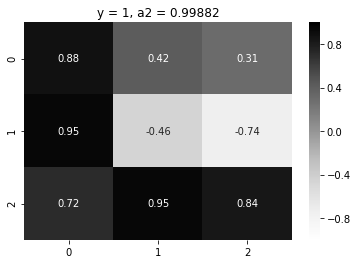

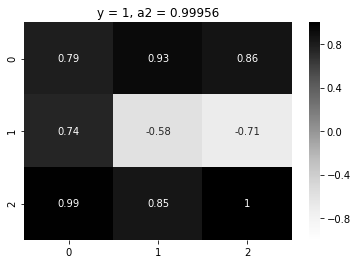

In [22]:
for ii in range(3):
    plt.figure()
    plot_grid(X_train[ii], vmin=bounds[0], vmax=bounds[1], cmap='Greys')
    aa2 = predict(X_train[ii], params_min, activation_funs)
    plt.title('y = {}, a2 = {:.5f}'.format(y_train[ii], aa2[0]))
    plt.show()

<font color="red">Hey that looks pretty good! I wonder if it's that good for all the letters. Let's check out the worst cases.</font>

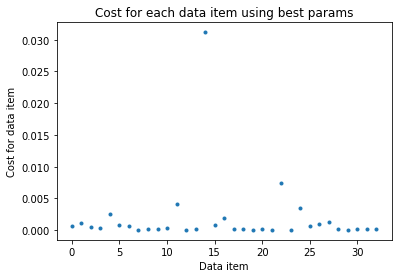

In [23]:
a2 = predict(X_train, params_min, activation_funs)
losses = (-y_train * np.log(a2)) - ((1-y_train) * np.log(1-a2))  # crossentropy for each data item
losses = losses.flatten()
plt.figure()
plt.plot(losses.flatten(), '.')
plt.xlabel('Data item')
plt.ylabel('Cost for data item')
plt.title('Cost for each data item using best params')
plt.show()

Worst predictions:


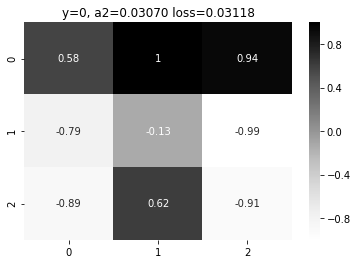

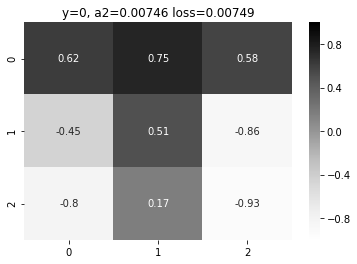

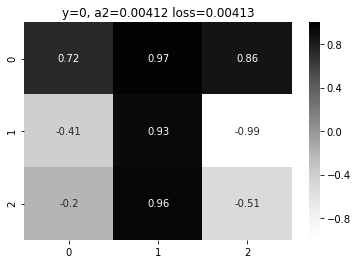

In [24]:
loss_order = np.argsort(losses.flatten())[::-1]
print('Worst predictions:')
for ii in range(3):
    idx = loss_order[ii]
    xx, yy = X_train[idx, :], y_train[idx]
    plt.figure()
    plot_grid(xx, vmin=bounds[0], vmax=bounds[1], cmap='Greys')
    aa2 = predict(xx, params_min, activation_funs)
    plt.title('y={}, a2={:.5f} loss={:.5f}'.format(yy, aa2[0], losses[idx]))
    plt.show()

<font color="red">Not bad! I reckon the accuracy will be 100% since a decision boundary at .5 (as is normal) would result in the correct classification for the very worst cases...let's check just in case!</font>

In [25]:
decision_boundary = .5
y_hat = (a2 > decision_boundary).astype(int)
correct_predictions = np.sum(y_train == y_hat)
accuracy = correct_predictions / len(y_train)
print('Training Accuracy = {}'.format(accuracy))

Training Accuracy = 1.0


<font color="red">The predictions look good - losses appear to be small and we have 100% accuracy! Apparently we have found a good parameter setting from a random search...so this problem *should* be easy to optimise! I don't expect you to have done this quick check, but it's a good example for how checking your code can lead to some informative results in itself. 
<br/>
<br/>
The above check turned out to be invaluable for me: my solution contained bugs in the backprop function (my cost function derivative was wrong) and, because I had a good idea about reasonable cost values from this analysis, I was able to better diagnose my issues.</font>

#### Backward pass tests

In [26]:
test_vals = np.linspace(-10, 10, 100)[:, np.newaxis]

In [27]:
np.sum([check_grad(linear, linear_derivative, xx) for xx in test_vals])

0.0

In [28]:
np.sum([check_grad(sigmoid, sigmoid_derivative, xx) for xx in test_vals])

2.7777965869979471e-07

In [29]:
test_vals = np.linspace(0.01, .99, 100)[:, np.newaxis]
c_1 = lambda x: crossentropy_cost(np.array([1]), x)
c_0 = lambda x: crossentropy_cost(np.array([0]), x)
c_deriv1 = lambda x: crossentropy_cost_derivative(np.array([1]), x)
c_deriv0 = lambda x: crossentropy_cost_derivative(np.array([0]), x)

In [30]:
np.sum([check_grad(c_1, c_deriv1, xx) for xx in test_vals])

0.0001224346388652986

In [31]:
np.sum([check_grad(c_0, c_deriv0, xx) for xx in test_vals])

0.00012244289554885768

### ========== Question 3.2 ==========

Did you need a network this large to do this classification task? Give the values for the parameters of a network with no hidden layers, one output node, and an output activation function of a sigmoid that would get 100% accuracy. This network only has 9 parameters.

*Your answer goes here*

The 'C' character data should be close to -1 in the centre square, whereas the 'T' data is close to 1. This means that all we need to do is return that value (passed through a sigmoid) to get 100% accuracy! Any weight vector with a positive value in index 4 (the $5^{th}$ entry) and zeros everywhere else will produce the desired result. 

In fact, there don't even need to be zeros everywhere else, so long as the sum is always >.5 for T and <.5 for C.

### ========== Question 3.3 ==========

You should recognise the model described in question 3.2. What is it?

*Your answer goes here*

It's a logistic regression!

### ========== Question 3.4 ==========

Why did I create input data, `X`, that was between [-1, 1] i.e. why wasn't it between [0, 1] like normal?! Would the model specified in question 3.1 above have worked if `X` was in [0, 1]? Explain why or why not.

*Hint: if you're stuck, you can try it out by generating some new data and trying to fit it.*

*Your answer goes here*

No, it wouldn't have worked. The reason is that, regardless of how negative the learned parameters are, if you input a 0, multiplying it will never make it negative. Therefore, as the calculations are passed forward to the final sigmoid activation, the output activations will always be >= 0.5. The cost would still probably push us in the correct direction but your network would get very frustrated trying to predict outputs of `0` (`T` data).

This could be solved by including a bias parameter at each layer. Now you can make your hidden layer activation negative despite the input being 0. To simplify things, I chose to change the data instead!!! Below is some code that shows empirically that it doesn't work:

In [32]:
bounds = [0, 1]
X_, y_, y_labels_ = load_letters(categories=['T', 'C'], 
                              num_obs=[25, 25],
                              bounds=bounds,
                              beta_params=[[1, 8], [8, 1]],
                              shuffle=True, 
                              random_state=42)

X_tr, X_val, y_tr, y_val = train_test_split(
    X_, y_, test_size=0.33, random_state=42)

In [33]:
np.random.seed(random_seed)
W1 = np.random.randn(3, 9)
W2 = np.random.randn(1, 3)
params2 = [W1, W2]

# Things to store
cost_per_epoch = dict(train=[], valid=[])
accuracy_per_epoch = dict(train=[], valid=[])
params2_per_epoch = []

# Training loop
print('Beginning Training!\n{}\n'.format('-'*len('Beginning Training!')))
print(' {:^10} | {:^10} | {:^10} | {:^10} | {:^10} '.\
      format('Epoch', 'Train Cost', 'Valid Cost', 'Train Acc', 'Valid Acc'))
print(' {0}   {0}   {0}   {0}   {0} '.format(10*'-'))

for ii in range(nr_epochs):
    # WARNING: 
    # If your network is large and/or you are doing many epochs, it's not 
    # sensible to save the parameters every epoch - for this toy problem it's ok
    params2_per_epoch.append(copy.deepcopy(params2))  # without deepcopy, python will
                                                    # use a pointer only, resulting
                                                    # in a final parameter list with
                                                    # nr_epochs identical sets of params!
    # Forward pass
    fwd_pass_data = predict(X_tr, params2, activation_funs, return_all=True)
    activations = fwd_pass_data[0]

    a_out = dict(train=activations[-1],  # this is just to avoid calculating train output activations twice
                 valid=predict(X_valid, params2, activation_funs, return_all=False))
    for dataset_name, (XX, yy) in dict(train=(X_tr, y_tr), 
                                       valid=(X_val, y_val)).iteritems():
        aa = a_out[dataset_name]
        accuracy_per_epoch[dataset_name].append(get_accuracy(yy, aa, decision_boundary))
        cost_per_epoch[dataset_name].append(cost_fun(yy, aa))
    
    print(' {:>10d} | {:<10.7f} | {:<10.7f} | {:<10.7f} | {:<10.7f} '.\
          format(ii, cost_per_epoch['train'][ii], cost_per_epoch['valid'][ii], 
                 accuracy_per_epoch['train'][ii], accuracy_per_epoch['valid'][ii]))
    
    # Don't do backward pass on the final epoch (just to avoid repeating code) 
    if ii == nr_epochs - 1:
        break
    
    # Backward pass
    params2 = backward_pass(y_train, params2, fwd_pass_data, cost_fun_derivative, 
                           activation_funs_derivatives, learning_rate=learning_rate)

Beginning Training!
-------------------

   Epoch    | Train Cost | Valid Cost | Train Acc  | Valid Acc  
 ----------   ----------   ----------   ----------   ---------- 
          0 | 1.3874982  | 0.7580890  | 0.5151515  | 0.5294118  
          1 | 1.1308805  | 0.7261004  | 0.5151515  | 0.4117647  
          2 | 0.9719064  | 0.7245983  | 0.5151515  | 0.4705882  
          3 | 0.8945414  | 0.7389030  | 0.5151515  | 0.4117647  
          4 | 0.8688811  | 0.7572126  | 0.5151515  | 0.4705882  
          5 | 0.8670303  | 0.7733047  | 0.5151515  | 0.4705882  
          6 | 0.8728960  | 0.7855275  | 0.3636364  | 0.4705882  
          7 | 0.8798117  | 0.7942725  | 0.1212121  | 0.4705882  
          8 | 0.8857070  | 0.8004122  | 0.0606061  | 0.4705882  
          9 | 0.8902527  | 0.8047373  | 0.0606061  | 0.4705882  
         10 | 0.8936488  | 0.8078391  | 0.0303030  | 0.4705882  
         11 | 0.8961879  | 0.8101277  | 0.0303030  | 0.4705882  
         12 | 0.8981233  | 0.8118779  | 0.0303030

### ========== Question 3.5 [EXTENSION] ==========

Create a dataset which makes the problem harder. Have a look at the dataset generation code. You can use the arguments to create data with:
* more letters (make the problem a multiclass classification)
    * You'll need to implement the multiclass version of the sigmoid for the output activation function - [the softmax](https://en.wikipedia.org/wiki/Softmax_function) (and of course it's derivative) 
* increase the noise on the data

Some other things you could implement:
* include rotated letters in the data
* make larger data (bigger than 3x3)
* make the letters non-centred e.g. 5x5 data with 3x3 letters in 1 of 9 different places

You'll probably need to adapt the code you wrote in 3.1, but you can probably copy and paste most of it. For an additional challenge: introduce [bias parameters](http://neuralnetworksanddeeplearning.com/chap1.html) and create your `X` data in range [0, 1] (i.e. set the bounds argument to [0, 1])...

Some other things to try if you get code happy:
* Implement stochastic gradient descent updates (updating parameters every training example, as opposed to every epoch) - tip: randomise data order each epoch
* Implement batch gradient descent updates - tip: randomise data order each epoch

**Requirements**:
1. Describe the modelling problem and your input data. Plot some examples of the data
1. Write down the model specification (I should be able to reproduce your model with this description):
    * number of nodes in each layer
    * a description of the parameters to learn (and a total number of parameters)
    * the activation functions used for each layer
    * cost function used
1. All the outputs asked for in Question 3.1: loss per epoch plot, final parameters, a weight against epoch plot, and example predictions

*Your answer goes here*

In [34]:
# Your code goes here

## Part 4 - Implementation with Sklearn

### ========== Question 4.1 ==========

If you did Question 3.1, this should be a breeze! Use the same data and perform the same modelling task. This time you can use Sklearn's Neural Network object [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier).


Before you begin, read the [introduction](http://scikit-learn.org/stable/modules/neural_networks_supervised.html) (sections 1.17.1 and 1.17.2 at a minimum, 1.17.5, 1.17.6, 1.17.7 are recommended).

In [35]:
# Your code goes here
mlp = MLPClassifier(hidden_layer_sizes=(3, ), 
                    activation='identity',
                    solver='sgd',
                    alpha=0, 
                    batch_size=X_train.shape[0],
                    learning_rate='constant',
                    learning_rate_init=0.3, 
                    max_iter=100,
                    shuffle=False, 
                    random_state=None,
                    tol=0.0001, 
                    verbose=True, 
                    warm_start=False, 
                    momentum=0, 
                    nesterovs_momentum=False, 
                    early_stopping=False, 
                    validation_fraction=0)
mlp.fit(X_train, y_train)

Iteration 1, loss = 1.88036666
Iteration 2, loss = 0.35444904
Iteration 3, loss = 0.18512011
Iteration 4, loss = 0.12419522
Iteration 5, loss = 0.09198063
Iteration 6, loss = 0.07227744
Iteration 7, loss = 0.05909686
Iteration 8, loss = 0.04971949
Iteration 9, loss = 0.04273999
Iteration 10, loss = 0.03736263
Iteration 11, loss = 0.03310494
Iteration 12, loss = 0.02965830
Iteration 13, loss = 0.02681662
Iteration 14, loss = 0.02443735
Iteration 15, loss = 0.02241889
Iteration 16, loss = 0.02068698
Iteration 17, loss = 0.01918618
Iteration 18, loss = 0.01787430
Iteration 19, loss = 0.01671869
Iteration 20, loss = 0.01569371
Iteration 21, loss = 0.01477895
Iteration 22, loss = 0.01395801
Iteration 23, loss = 0.01321753
Iteration 24, loss = 0.01254654
Iteration 25, loss = 0.01193594
Iteration 26, loss = 0.01137815
Iteration 27, loss = 0.01086678
Iteration 28, loss = 0.01039640
Iteration 29, loss = 0.00996242
Iteration 30, loss = 0.00956087
Iteration 31, loss = 0.00918834
Iteration 32, los

MLPClassifier(activation='identity', alpha=0, batch_size=33, beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(3,), learning_rate='constant',
       learning_rate_init=0.3, max_iter=100, momentum=0,
       nesterovs_momentum=False, power_t=0.5, random_state=None,
       shuffle=False, solver='sgd', tol=0.0001, validation_fraction=0,
       verbose=True, warm_start=False)

### ========== Question 4.2 ==========

The learned parameters are stored in the fitted sklearn [MLPClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier) object **as two separate attributes**.

1. Print the parameters learned by your fitted model
1. Print the total number of parameters learned

Look at the number of parameters described in question 3.1 (you do not need to have done this question 3.1 - just read its description). Below the code:

1. Explain why the number of parameters learned by sklearn is different from the number specified in 3.1?

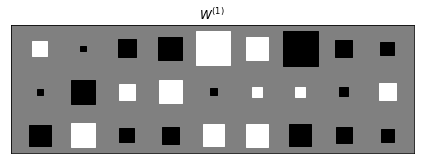

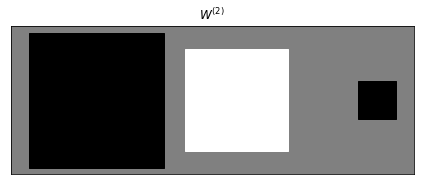

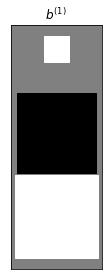

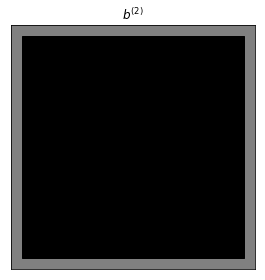

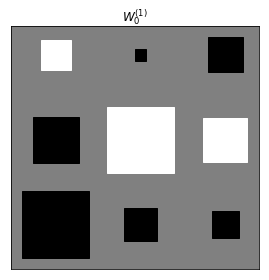

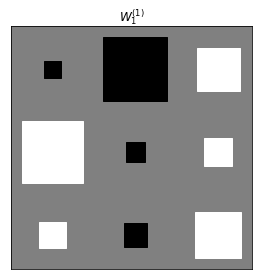

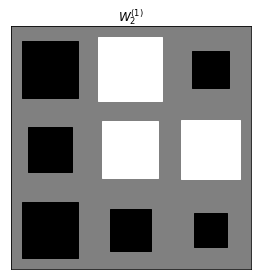

In [36]:
# Your code goes here
final_Ws = [mat.T for mat in mlp.coefs_]  # Just transposing so we can use same code as above
final_bees = mlp.intercepts_

for ii, W in enumerate(final_Ws):
    plt.figure()
    hinton(W.T)
    plt.title('$W^{{({})}}$'.format(ii + 1))
    plt.tight_layout()
    plt.show()

for ii, b in enumerate(final_bees):
    plt.figure()
    hinton(b[np.newaxis, :])
    plt.title('$b^{{({})}}$'.format(ii + 1))
    plt.tight_layout()
    plt.show()
    
W1 = final_Ws[0]
for ii in range(3):
    plt.figure()
    hinton(W1[ii, :].reshape(3, 3).T)
    plt.title('$W^{{({})}}_{}$'.format(1, ii))
    plt.savefig('img/hinton_W{}_{}.png'.format(1, ii), dpi=100, bbox_inches='tight')
    plt.tight_layout()
    plt.show()

*Your answer goes here*

The sklearn object will fit bias parameters by default (it calls them intercepts). We did not fit them in our code in 3.1. You can read more about the bias parameter and how to fit it [here](http://neuralnetworksanddeeplearning.com/chap1.html).

# [Please sir...I want some more](https://www.youtube.com/watch?v=Ex2r86G0sdc)

Well done, you successfully covered the basics of Neural Networks!

If you enjoyed this lab, you'll love another course @ Edinburgh: [Machine Learning Practical](https://github.com/CSTR-Edinburgh/mlpractical). Check it out.

### Next steps

The first thing to do, if you haven't already, is do the extension question 3.5. **In particular, you should implement bias parameters in your model code**.

Next, go back to the very top of the notebook where I detail things I will not cover. Pick some words you don't understand (perhaps along with the keyword 'example' or 'introduction') and have fun reading/watching some tutorials about them online. Code up what you have learned; if you can code it up without peeking, you know you have understood it very well indeed. Another good "starter for 10" google is "a review of neural networks for [images|text|music|bat detection|captioning images|generation|...]".

Here are some things that you might find fun to read:
* [Visualising networks learning](http://playground.tensorflow.org/#activation=tanh&batchSize=10&dataset=circle&regDataset=reg-plane&learningRate=0.03&regularizationRate=0&noise=5&networkShape=3&seed=0.42978&showTestData=false&discretize=false&percTrainData=50&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=classification&initZero=false&hideText=false)
* [Trying to understand what features are learned by Deep Nets](https://distill.pub/2017/feature-visualization/)
* [Modelling sound waves](https://deepmind.com/blog/wavenet-generative-model-raw-audio/)
   * ...and using that to [encode instruments](https://magenta.tensorflow.org/nsynth)
* An [Introduction to LSTMs](http://colah.github.io/posts/2015-08-Understanding-LSTMs/) and their [unreasonable effectiveness](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)
* How to encode the entire meaning of a word [in a few numbers](http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/)
* [Convolutions for text data?!](http://www.wildml.com/2015/11/understanding-convolutional-neural-networks-for-nlp/)

### Learning resources

Also:
* [there](http://ufldl.stanford.edu/tutorial/supervised/MultiLayerNeuralNetworks/)
* [are](http://neuralnetworksanddeeplearning.com/chap1.html)
* [literally](https://www.coursera.org/learn/machine-learning)
* [so](https://www.coursera.org/learn/neural-networks)
* [many](http://deeplearning.net/)
* [learning](http://datasciencemasters.org/)
* [resources](https://metacademy.org/graphs/concepts/backpropagation)
* [online!](http://www.deeplearningbook.org/)

(about neural nets etc.)

In all seriousness, make sure you check out [metacademy](https://metacademy.org/). You can search for a topic and it gives you a list of free resources, an estimated time you need to understand it, and prerequisite topics.

# Attributions

Parts of this lab were inspired by  D. E. Rumelhart, G. E. Hinton, and R. J. Williams, Parallel distributed processing: Explorations
in the microstructure of cognition, vol. 1, MIT Press, Cambridge, MA, USA, 1986,
pp. 318–362.


Thanks also to:
* [3 Blue 1 Brown](https://www.youtube.com/channel/UCYO_jab_esuFRV4b17AJtAw)
* [Michael Nielsen](http://neuralnetworksanddeeplearning.com)
* [Christopher Olah](http://colah.github.io/)

for producing some excellent visualisations and learning resources and providing them free of charge.

Additionally, many thanks to the developers of open source software, in particular:
* [Numpy](http://www.numpy.org/)
* [Scipy](https://www.scipy.org/)
* [Sklearn](http://scikit-learn.org/stable/)
* [Matplotlib](https://matplotlib.org/)
* [Jupyter](http://jupyter.org/)
* and of course [Python](https://www.python.org/) itself!

your work is invaluable and appreciated.

# Credits

This lab was created by [James Owers](https://jamesowers.github.io/) in November 2017 and reviewed by [Patric Fulop](https://www.inf.ed.ac.uk/people/students/Patric_Fulop.html).